# Classificatore basato su SVM lineari e word embedding

Il terzo classificatore dovrà utilizzare una rappresentazione vettoriale del testo costruita a partire da word embedding. I modelli di embedding da utilizzare potranno essere, ad esempio, quelli forniti dal sito ItaliaNLP Lab (per l’italiano:  http://www.italianlp.it/resources/italian-word-embeddings/, per l’inglese: http://www.italianlp.it/t2k-resources/en/w2v/ukwac/ukwac128.sqlite).

In questo caso si richiede di:

- testare diverse rappresentazioni del testo che variano rispetto al modo di combinare gli embedding delle singole parole e/o rispetto alle categorie grammaticali delle parole prese in considerazione
- valutare i vari modelli sul validation set
- testare sul test set il sistema che ha ottenuto le migliori prestazioni nella fase di validazione.

N.B: analisi svolte sul dataset senza splitting dei clitici e delle preposizioni

In [619]:
import numpy as np
import os

Definizione della classi Document e Token
(il documento è rappresentato come lista di token e non di frasi)

In [620]:
class Document:
    
    def __init__(self, document_path):
        self.document_path = document_path
        self.doc_id = None
        self.split = None
        self._load_doc_info(document_path)
        self.tokens = []
        self.features = None
        self.count = None # percentuale di parole trovate nei word embeddings
        
    def _load_doc_info(self, document_path):
        self.doc_id = (document_path.split('.')[0]).split("/")[-1]
        self.split = self.doc_id.split('_')[-1]
        self.autrice = self.doc_id.split('_')[0]

    def get_num_tokens(self):
        return len(self.tokens)
             
    def __str__(self):
        return ' '.join([token.word for token in self.tokens])
    
    
class Token:
    
    def __init__(self, word, pos):
        self.word = word
        self.pos = pos

    def __str__(self):
        return f'Word = {self.word}, POS = {self.pos}'

## Caricamento dei word embeddings

In [621]:
embeddings_dim = 128
embeddings_path = f'itwac{embeddings_dim}.txt'

Leggiamo il file dei word embeddings e creiamo un dizionario della forma:

- Chiave = parola
- Valore = embedding della parola

In [622]:
def load_word_embeddings(src_path):
    embeddings = dict()
    for line in open(src_path, 'r'):
        line = line.strip().split('\t')
        word = line[0]
        embedding = line[1:]
        embedding = [float(comp) for comp in embedding] # convertiamo le componenti dell'embedding in float
        embeddings[word] = np.asarray(embedding) # trasformiamo la lista delle componenti in un vettore di numpy
    return embeddings

In [623]:
embeddings = load_word_embeddings(embeddings_path)

In [624]:
len(embeddings)

1247492

In [625]:
embeddings['vedersi'] #, embeddings['veder-']

array([ 0.09829128, -0.00466396,  0.12274315, -0.00645867,  0.02171866,
       -0.01775092,  0.20173289, -0.0126764 , -0.13903011,  0.14330961,
        0.15038787, -0.00662153,  0.03522438,  0.05580687, -0.06235559,
        0.16190079,  0.13125402,  0.09466209, -0.02967671,  0.06027041,
        0.00226344, -0.04958551,  0.14477645, -0.12636545, -0.07517902,
       -0.0059378 , -0.15247029, -0.07902947,  0.05534033, -0.06163132,
       -0.04358011, -0.11407799, -0.05476963,  0.00276546,  0.04666484,
       -0.02525456,  0.12073468,  0.14676426, -0.00958022,  0.05849574,
       -0.13112271, -0.04931208,  0.05483235, -0.00634756, -0.21491098,
        0.05190172,  0.1771792 ,  0.02620396,  0.06802528, -0.08378372,
        0.0625739 ,  0.04612483, -0.12579846, -0.05673553, -0.02175681,
       -0.19563943,  0.08836281,  0.09511665,  0.1184418 , -0.09940016,
        0.05089193, -0.0161554 ,  0.04401183, -0.03545505,  0.04018058,
        0.13875584,  0.10942651,  0.03830871,  0.08303873,  0.01

## Caricamento del dataset

#### Normalizzazione delle parole

- Numbers:
    - Integer numbers between 0 and 2100 were kept as original
    - Each integer number greater than 2100 is mapped in a string which represents the number of digits needed to store the number (ex: 10000 -> DIGLEN_5)
    - Each digit in a string that is not convertible to a number must be converted with the following char: @Dg. This is an example of replacement (ex: 10,234 -> @Dg@Dg,@Dg@Dg@Dg)
- Words:
    - A string starting with lower case character must be lowercased (e.g.: (“aNtoNio” -> “antonio”), (“cane” -> “cane”))
    - A string starting with an upcased character must be capitalized (e.g.: (“CANE” -> “Cane”, “Antonio”-> “Antonio”))

In [626]:
import re

def get_digits(text):
    try:
      val = int(text)
    except:
      text = re.sub(r'\d', '@Dg', text)
      return text
    if val >= 0 and val < 2100:
      return str(val)
    else:
      return "DIGLEN_" + str(len(str(val)))

def normalize_text(word):
    if "http" in word or ("." in word and "/" in word):
      word = str("___URL___")
      return word
    if len(word) > 26:
      return "__LONG-LONG__"
    new_word = get_digits(word)
    if new_word != word:
      word = new_word
    if word[0].isupper():
      word = word.capitalize()
    else:
      word = word.lower()
    return word

#### Estrazione dei token

In [627]:
# Funzione che estrae i token dai file, considerando i clitici non splittati

def get_tokens_from_file(src_path):
    document_tokens = []
    lines_to_skip = 0
    take_pos = False
    for line in open(src_path, 'r'):
        # print(f'\nRiga: {line.strip()}')
        if line[0].isdigit():
            splitted_line = line.strip().split('\t')
            if '-' in splitted_line[0]:
                # print('Ho trovato un - ')
                skip_ids = splitted_line[0].split('-')
                # print('Indici da saltare', skip_ids)
                lines_to_skip = int(skip_ids[1]) - int(skip_ids[0]) + 1 # l'indice ci indica quali righe saltare
                take_pos = True # booleano che indica che dobbiamo prendere la pos della prossima parola
                word = normalize_text(splitted_line[1])
                pos = splitted_line[3]
                token = Token(word=word, pos=None) # inizializziamo il token con la forma, il pos lo prendiamo nella riga successiva
                # print(f'Preso token {word}')
                document_tokens.append(token)
            else:
                if lines_to_skip == 0:   
                    word = normalize_text(splitted_line[1])
                    pos = splitted_line[3]
                    token = Token(word=word, pos=pos)
                    # print(f'Preso token {word}')
                    document_tokens.append(token)
                if take_pos:
                    pos = splitted_line[3]
                    document_tokens[-1].pos = pos
                    take_pos = False
                lines_to_skip = max(0, lines_to_skip-1)
    return document_tokens

In [628]:
dataset_conllu = "Dataset conllu/"

In [629]:
# Carico tutti i documenti sulla stessa lista, così da ottenere features comuni nelle fasi successive
lista_documenti = []

for cartella, sottocartelle, files in os.walk(dataset_conllu):
    for file in files:
        if file.endswith(".conllu"):
            file_path = cartella+"/"+file
            document = Document(file_path)
            document_tokens = get_tokens_from_file(file_path)
            document.tokens = document_tokens
            lista_documenti.append(document)


In [630]:
print(lista_documenti[0])

Non durai fatica a stare a letto tutto il giorno perchè ero desiderosa di solitudine , di silenzio , di una libertà piena e completa che mi permettesse di ritrovarmi colla mia coscienza . Volevo indagare la folla di pensieri contradditori che mi agitavano commisti a irritazione , a sdegno , a tristezza e a non so quale recondita oscura soddisfazione che non sapevo decifrare .


## Estrazione delle features

### Primo tentativo: media semplice

In [631]:
# Creo una copia della lista dei documenti per utlizzarla nel primo tentativo

lista_doc_mean = lista_documenti.copy()

In [632]:
def compute_embeddings_mean(document_embeddings):
    sum_array = np.sum(document_embeddings, axis=0)
    mean_array = np.divide(sum_array, len(document_embeddings))
    return mean_array

Metodo che calcola la media di tutti i word embeddings di un documento

In [633]:
def compute_all_embeddings_mean(document_tokens):
    document_embeddings = []
    count = 0
    for token in document_tokens:
        word = token.word
        if word in embeddings:
            document_embeddings.append(embeddings[word])
            count +=1
    
   # se nel file non trova word embeddings, crea una rappresentazione con tutti zeri (32 componenti)
    if len(document_embeddings) == 0:
        mean_document_embeddings = np.zeros(embeddings_dim)
    else:
        mean_document_embeddings = compute_embeddings_mean(document_embeddings)
    return mean_document_embeddings, count

#### Creazione della matrice delle features del training set

Ogni documento è rappresentato dall'aggregazione dei word embeddings delle parole (con la media)

In [634]:
def extract_features(documents):
    for document in documents:
        # document_embeddings = compute_all_embeddings_mean(document.tokens)
        document_embeddings, count = compute_all_embeddings_mean(document.tokens)
        # document_embeddings = compute_filtered_embeddings_sep_means(document.tokens)
        document.features = document_embeddings
        # percentuale di parole trovate
        document.count = count/len(document.tokens)

In [635]:
extract_features(lista_doc_mean)

In [636]:
lista_doc_mean[0].features

array([ 0.08231819,  0.00127631,  0.05971173, -0.04420872,  0.03996317,
        0.03164021,  0.05341535, -0.0083813 ,  0.07028662,  0.0526683 ,
        0.04971379,  0.03694663, -0.01269909,  0.01631997, -0.03175304,
        0.05769257,  0.03170019,  0.03571441, -0.05070151,  0.00861872,
       -0.00040228,  0.00316244,  0.02591021, -0.06097868, -0.00099822,
       -0.03361938, -0.06833996,  0.01026618,  0.03675307, -0.02828611,
       -0.0131058 , -0.01021078,  0.00587564,  0.03970542, -0.02026116,
       -0.02621305,  0.07865064,  0.06744671, -0.0002251 , -0.03244915,
        0.00931579,  0.01052976,  0.01524349, -0.08058261, -0.05373249,
       -0.01091376,  0.04393956,  0.03352186, -0.02085249, -0.02940334,
        0.04088787,  0.04787734, -0.02458808,  0.03011065, -0.03131214,
       -0.03541094,  0.04167812,  0.07171152,  0.04357962, -0.02381211,
        0.06358521,  0.01244969, -0.03666805,  0.06081332,  0.03639738,
        0.01854805,  0.02672896,  0.05142977, -0.03688202, -0.02

In [637]:
lista_doc_mean[0].count

0.9848484848484849

#### Divisione tra training, test e validation

In [638]:
def train_test_val_split(all_documents):
    train_features_dict, train_labels = [], []
    test_features_dict, test_labels = [], []
    val_features_dict, val_labels = [], []

    for document in all_documents:
        if document.split == 'training':
            train_features_dict.append(document.features)
            train_labels.append(document.autrice)
        elif document.split == 'validation':
            val_features_dict.append(document.features)
            val_labels.append(document.autrice)
        else:
            test_features_dict.append(document.features)
            test_labels.append(document.autrice)
    
    return train_features_dict, train_labels, test_features_dict, test_labels, val_features_dict, val_labels

In [639]:
train_features_mean, train_labels_mean, test_features_mean, test_labels_mean, val_features_mean, val_labels_mean = train_test_val_split(lista_doc_mean)

In [640]:
len(train_features_mean), len(train_labels_mean), len(test_features_mean), len(test_labels_mean), len(val_features_mean), len(val_labels_mean)

(3000, 3000, 300, 300, 300, 300)

In [641]:
X_train_mean = np.array(train_features_mean)
y_train_mean = np.array(train_labels_mean)
X_test_mean = np.array(test_features_mean)
y_test_mean = np.array(test_labels_mean)
X_val_mean = np.array(val_features_mean)
y_val_mean = np.array(val_labels_mean)

In [642]:
X_train_mean.shape

(3000, 128)

#### Normalizzazione

In [643]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_X_train_mean = scaler.fit_transform(X_train_mean)

#### Classificazione

In [644]:
from sklearn.svm import LinearSVC

svc = LinearSVC(dual=False)
svc.fit(scaled_X_train_mean, y_train_mean)

LinearSVC(dual=False)

In [645]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

scaled_X_val_mean = scaler.transform(X_val_mean)
val_predictions_mean = svc.predict(scaled_X_val_mean)

In [646]:
print(classification_report(y_val_mean, val_predictions_mean,  zero_division=0))

              precision    recall  f1-score   support

     colombi       0.57      0.78      0.66       100
       neera       0.79      0.55      0.65       100
       serao       0.83      0.78      0.80       100

    accuracy                           0.70       300
   macro avg       0.73      0.70      0.70       300
weighted avg       0.73      0.70      0.70       300



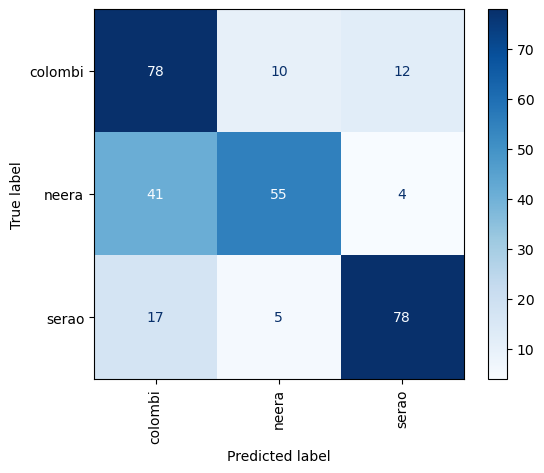

In [647]:
ConfusionMatrixDisplay.from_predictions(val_labels_mean, val_predictions_mean, xticks_rotation='vertical', cmap='Blues')

## Prestazioni sul Test set della configurazione più performante

Media degli embeddings non concatenati

In [648]:
scaled_X_test_mean = scaler.transform(X_test_mean)
test_predictions_mean = svc.predict(scaled_X_test_mean)

In [649]:
print(classification_report(y_test_mean, test_predictions_mean,  zero_division=0))

              precision    recall  f1-score   support

     colombi       0.58      0.79      0.67       100
       neera       0.79      0.55      0.65       100
       serao       0.77      0.72      0.74       100

    accuracy                           0.69       300
   macro avg       0.71      0.69      0.69       300
weighted avg       0.71      0.69      0.69       300



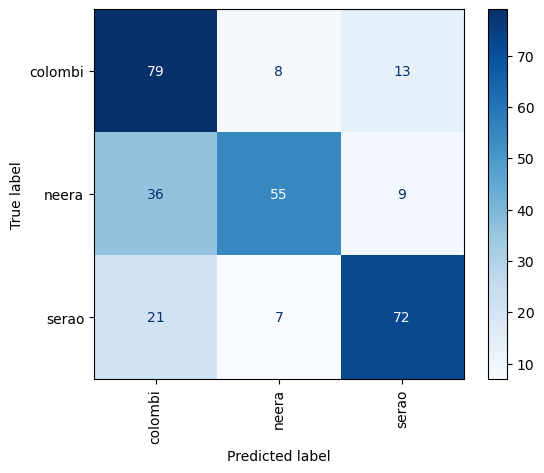

In [650]:
ConfusionMatrixDisplay.from_predictions(test_labels_mean, test_predictions_mean, xticks_rotation='vertical', cmap='Blues')

## Altri tentativi meno performanti

(per comodità, alcune celle di codice sono state aggregate)

### Secondo tentativo: medie dei word embedding delle parole piene concatenate

Calcolo la media separatamente dei word embedding di aggettivi, nomi e verbi, e concateno i 3 vettori ottenuti.

In [651]:
# Creo una copia della lista dei documenti per utlizzarla nel primo tentativo

lista_doc_mean_concatenate = lista_documenti.copy()

In [652]:
def compute_filtered_embeddings_sep_means(document_tokens):
    adj_embeddings = []
    noun_embeddings = []
    verb_embeddings = []
    
    for token in document_tokens:
        word = token.word
        pos = token.pos
        if word in embeddings and pos in ['ADJ']:
            adj_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['NOUN']:
            noun_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['VERB']:
            verb_embeddings.append(embeddings[word])
    
    if len(adj_embeddings) == 0:
        mean_adj_embeddings = np.zeros(embeddings_dim)
    else:
        mean_adj_embeddings = compute_embeddings_mean(adj_embeddings)
        
    if len(noun_embeddings) == 0:
        mean_noun_embeddings = np.zeros(embeddings_dim)
    else:
        mean_noun_embeddings = compute_embeddings_mean(noun_embeddings)
        
    if len(verb_embeddings) == 0:
        mean_verb_embeddings = np.zeros(embeddings_dim)
    else:
        mean_verb_embeddings = compute_embeddings_mean(verb_embeddings)  
    
    
    mean_document_embeddings = np.concatenate([mean_adj_embeddings, mean_noun_embeddings, mean_verb_embeddings], axis=None)
    return mean_document_embeddings

In [653]:
def extract_features_filtered(documents):
    for document in documents:
        # document_embeddings = compute_all_embeddings_mean(document.tokens)
        document_embeddings = compute_filtered_embeddings_sep_means(document.tokens)
        # document_embeddings = compute_filtered_embeddings_sep_means(document.tokens)
        document.features = document_embeddings

In [654]:
extract_features_filtered(lista_doc_mean_concatenate)

In [655]:
lista_doc_mean_concatenate[0].features

array([ 9.21041233e-02, -2.13116006e-02,  5.81576540e-02,  5.54699606e-02,
       -5.63036726e-03,  3.65469046e-02,  2.35771763e-02,  5.73316310e-02,
        7.65379930e-02, -6.31375494e-03, -3.34560527e-02,  8.19045594e-02,
       -4.11692473e-02, -2.46838235e-02, -2.29652129e-02,  6.17113098e-02,
       -4.53700774e-02,  3.17084165e-02,  1.53175321e-02,  2.08843487e-02,
        4.80283188e-02,  5.21063292e-02,  6.35938860e-02, -7.89405111e-02,
       -1.64409181e-02, -9.49351519e-02,  1.11724477e-02,  7.58670107e-03,
       -2.61807535e-03,  2.95654168e-03, -8.14378276e-02,  9.10063597e-02,
       -2.18736806e-02,  1.05503178e-02, -1.59386330e-02, -2.07463290e-02,
        8.00355130e-02,  1.10229108e-02,  2.25948412e-02, -1.52071327e-02,
        2.81596171e-02,  9.49384800e-03,  4.97113603e-04, -6.14836651e-02,
       -4.75778918e-02, -2.80898823e-02,  6.69533151e-02, -2.86336088e-02,
       -2.94270092e-02, -3.52860397e-02, -1.43830351e-02,  4.71959569e-02,
       -5.20478820e-02, -

#### Divisione tra training, test e validation

In [656]:
train_features_mean_concatenate, train_labels_mean_concatenate, test_features_mean_concatenate, test_labels_mean_concatenate, val_features_mean_concatenate, val_labels_mean_concatenate = train_test_val_split(lista_doc_mean_concatenate)

X_train_mean_concatenate = np.array(train_features_mean_concatenate)
y_train_mean_concatenate = np.array(train_labels_mean_concatenate)
X_test_mean_concatenate = np.array(test_features_mean_concatenate)
y_test_mean_concatenate = np.array(test_labels_mean_concatenate)
X_val_mean_concatenate = np.array(val_features_mean_concatenate)
y_val_mean_concatenate = np.array(val_labels_mean_concatenate)

scaled_X_train_mean_concatenate = scaler.fit_transform(X_train_mean_concatenate)
svc.fit(scaled_X_train_mean_concatenate, y_train_mean_concatenate)

scaled_X_val_mean_concatenate = scaler.transform(X_val_mean_concatenate)

val_predictions_mean_concatenate = svc.predict(scaled_X_val_mean_concatenate)
print(classification_report(y_val_mean_concatenate, val_predictions_mean_concatenate,  zero_division=0))

              precision    recall  f1-score   support

     colombi       0.41      0.47      0.44       100
       neera       0.46      0.37      0.41       100
       serao       0.44      0.45      0.44       100

    accuracy                           0.43       300
   macro avg       0.43      0.43      0.43       300
weighted avg       0.43      0.43      0.43       300



### Terzo tentativo: medie dei word embedding di alcune pos, concatenate

Calcolo la media separatamente dei word embedding di adj, noun, verb, aux, det, adp e pron e concateno i vettori ottenuti.

In [657]:
# Creo una copia della lista dei documenti per utlizzarla nel primo tentativo

lista_doc_pos = lista_documenti.copy()

In [658]:
def compute_concatenate_embeddings_sep_means(document_tokens):
    adj_embeddings = []
    noun_embeddings = []
    verb_embeddings = []
    aux_embeddings = []
    det_embeddings = []
    adp_embeddings = []
    pron_embeddings = []
    
    for token in document_tokens:
        word = token.word
        pos = token.pos
        if word in embeddings and pos in ['ADJ']:
            adj_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['NOUN']:
            noun_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['VERB']:
            verb_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['AUX']:
            aux_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['DET']:
            det_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['ADP']:
            adp_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['PRON']:
            pron_embeddings.append(embeddings[word])
        
        
    
    if len(adj_embeddings) == 0:
        mean_adj_embeddings = np.zeros(embeddings_dim)
    else:
        mean_adj_embeddings = compute_embeddings_mean(adj_embeddings)
        
    if len(noun_embeddings) == 0:
        mean_noun_embeddings = np.zeros(embeddings_dim)
    else:
        mean_noun_embeddings = compute_embeddings_mean(noun_embeddings)
        
    if len(verb_embeddings) == 0:
        mean_verb_embeddings = np.zeros(embeddings_dim)
    else:
        mean_verb_embeddings = compute_embeddings_mean(verb_embeddings)  
    
    if len(aux_embeddings) == 0:
        mean_aux_embeddings = np.zeros(embeddings_dim)
    else:
        mean_aux_embeddings = compute_embeddings_mean(aux_embeddings)

    if len(det_embeddings) == 0:
        mean_det_embeddings = np.zeros(embeddings_dim)
    else:
        mean_det_embeddings = compute_embeddings_mean(det_embeddings)
    
    if len(adp_embeddings) == 0:
        mean_adp_embeddings = np.zeros(embeddings_dim)
    else:
        mean_adp_embeddings = compute_embeddings_mean(adp_embeddings)
    
    if len(pron_embeddings) == 0:
        mean_pron_embeddings = np.zeros(embeddings_dim)
    else:
        mean_pron_embeddings = compute_embeddings_mean(pron_embeddings)
    
    mean_document_embeddings = np.concatenate([mean_adj_embeddings, mean_noun_embeddings, mean_verb_embeddings, mean_aux_embeddings, mean_det_embeddings, mean_adp_embeddings, mean_pron_embeddings], axis=None)
    return mean_document_embeddings

In [659]:
def extract_features_concatenate(documents):
    for document in documents:
        # document_embeddings = compute_all_embeddings_mean(document.tokens)
        document_embeddings = compute_concatenate_embeddings_sep_means(document.tokens)
        # document_embeddings = compute_filtered_embeddings_sep_means(document.tokens)
        document.features = document_embeddings

In [660]:
extract_features_concatenate(lista_doc_pos)

In [661]:
lista_doc_pos[0].features

array([ 9.21041233e-02, -2.13116006e-02,  5.81576540e-02,  5.54699606e-02,
       -5.63036726e-03,  3.65469046e-02,  2.35771763e-02,  5.73316310e-02,
        7.65379930e-02, -6.31375494e-03, -3.34560527e-02,  8.19045594e-02,
       -4.11692473e-02, -2.46838235e-02, -2.29652129e-02,  6.17113098e-02,
       -4.53700774e-02,  3.17084165e-02,  1.53175321e-02,  2.08843487e-02,
        4.80283188e-02,  5.21063292e-02,  6.35938860e-02, -7.89405111e-02,
       -1.64409181e-02, -9.49351519e-02,  1.11724477e-02,  7.58670107e-03,
       -2.61807535e-03,  2.95654168e-03, -8.14378276e-02,  9.10063597e-02,
       -2.18736806e-02,  1.05503178e-02, -1.59386330e-02, -2.07463290e-02,
        8.00355130e-02,  1.10229108e-02,  2.25948412e-02, -1.52071327e-02,
        2.81596171e-02,  9.49384800e-03,  4.97113603e-04, -6.14836651e-02,
       -4.75778918e-02, -2.80898823e-02,  6.69533151e-02, -2.86336088e-02,
       -2.94270092e-02, -3.52860397e-02, -1.43830351e-02,  4.71959569e-02,
       -5.20478820e-02, -

In [662]:
train_features_pos, train_labels_pos, test_features_pos, test_labels_pos, val_features_pos, val_labels_pos = train_test_val_split(lista_doc_pos)

X_train_pos = np.array(train_features_pos)
y_train_pos = np.array(train_labels_pos)
X_test_pos = np.array(test_features_pos)
y_test_pos = np.array(test_labels_pos)
X_val_pos = np.array(val_features_pos)
y_val_pos = np.array(val_labels_pos)

scaled_X_train_pos = scaler.fit_transform(X_train_pos)
svc.fit(scaled_X_train_pos, y_train_pos)
scaled_X_val_pos = scaler.transform(X_val_pos)

val_predictions_pos = svc.predict(scaled_X_val_pos)
print(classification_report(y_val_pos, val_predictions_pos,  zero_division=0))

              precision    recall  f1-score   support

     colombi       0.47      0.63      0.54       100
       neera       0.49      0.31      0.38       100
       serao       0.53      0.55      0.54       100

    accuracy                           0.50       300
   macro avg       0.50      0.50      0.49       300
weighted avg       0.50      0.50      0.49       300



### Quarto tentativo: somma dei word embeddings di ogni documento

In [663]:
# Creo una copia della lista dei documenti per utlizzarla nel primo tentativo

lista_doc_sum = lista_documenti.copy()

In [664]:
def compute_embeddings_sum(document_embeddings):
    sum_array = np.sum(document_embeddings, axis=0)
    return sum_array

In [665]:
# Funziona che calcola la somma dei word embeddings (se non ci sono embeddings, crea una lista di zeri)

def compute_all_embeddings_sum(document_tokens):
    document_embeddings = []
    
    for token in document_tokens:
        word = token.word
        if word in embeddings:
            document_embeddings.append(embeddings[word])
    
    if len(document_embeddings) == 0:
        sum_document_embeddings = np.zeros(embeddings_dim)
    else:
        sum_document_embeddings = compute_embeddings_sum(document_embeddings)
    return sum_document_embeddings

In [666]:
def extract_features_sum(documents):
    for document in documents:
        # document_embeddings = compute_all_embeddings_mean(document.tokens)
        document_embeddings = compute_all_embeddings_sum(document.tokens)
        # document_embeddings = compute_filtered_embeddings_sep_means(document.tokens)
        document.features = document_embeddings

In [667]:
extract_features_sum(lista_doc_sum)

In [668]:
lista_doc_sum[0].features

array([ 5.35068257,  0.08296005,  3.88126274, -2.87356689,  2.597606  ,
        2.0566139 ,  3.47199797, -0.54478419,  4.56863032,  3.42343961,
        3.23139657,  2.40153089, -0.8254411 ,  1.06079835, -2.06394743,
        3.75001697,  2.06051255,  2.32143674, -3.29559844,  0.56021674,
       -0.02614801,  0.20555885,  1.68416373, -3.96361436, -0.06488435,
       -2.18525967, -4.4420975 ,  0.66730187,  2.38894969, -1.83859732,
       -0.85187713, -0.66370081,  0.38191659,  2.58085225, -1.31697556,
       -1.70384832,  5.11229163,  4.38403596, -0.01463126, -2.10919502,
        0.60552652,  0.68443409,  0.99082693, -5.23786992, -3.492612  ,
       -0.7093946 ,  2.85607143,  2.17892073, -1.35541158, -1.91121709,
        2.65771163,  3.11202711, -1.59822521,  1.95719196, -2.03528916,
       -2.30171129,  2.70907778,  4.66124874,  2.83267524, -1.5477871 ,
        4.1330386 ,  0.80922955, -2.38342341,  3.95286592,  2.36582947,
        1.20562296,  1.73738232,  3.34293502, -2.39733145, -1.30

In [669]:
train_features_sum, train_labels_sum, test_features_sum, test_labels_sum, val_features_sum, val_labels_sum = train_test_val_split(lista_doc_sum)

X_train_sum = np.array(train_features_sum)
y_train_sum = np.array(train_labels_sum)
X_test_sum = np.array(test_features_sum)
y_test_sum = np.array(test_labels_sum)
X_val_sum = np.array(val_features_sum)
y_val_sum = np.array(val_labels_sum)

#### Normalizzazione
scaled_X_train_sum = scaler.fit_transform(X_train_sum)


svc.fit(scaled_X_train_sum, y_train_sum)
scaled_X_val_sum = scaler.transform(X_val_sum)

val_predictions_sum = svc.predict(scaled_X_val_sum)
print(classification_report(y_val_sum, val_predictions_sum,  zero_division=0))

              precision    recall  f1-score   support

     colombi       0.54      0.75      0.63       100
       neera       0.80      0.48      0.60       100
       serao       0.78      0.80      0.79       100

    accuracy                           0.68       300
   macro avg       0.71      0.68      0.67       300
weighted avg       0.71      0.68      0.67       300



### Quinto tentativo: massimo tra word embeddings di ogni documento

In [670]:
# Creo una copia della lista dei documenti per utlizzarla nel primo tentativo

lista_doc_max = lista_documenti.copy()

In [671]:
def compute_embeddings_max(document_embeddings):
    max_array = np.max(document_embeddings, axis=0)
    return max_array

In [672]:
def compute_all_embeddings_max(document_tokens):
    document_embeddings = []
    
    for token in document_tokens:
        word = token.word
        if word in embeddings:
            document_embeddings.append(embeddings[word])
    
    if len(document_embeddings) == 0:
        max_document_embeddings = np.zeros(embeddings_dim)
    else:
        max_document_embeddings = compute_embeddings_max(document_embeddings)
    return max_document_embeddings

In [673]:
def extract_features_max(documents):
    for document in documents:
        # document_embeddings = compute_all_embeddings_mean(document.tokens)
        document_embeddings = compute_all_embeddings_max(document.tokens)
        # document_embeddings = compute_filtered_embeddings_sep_means(document.tokens)
        document.features = document_embeddings

In [674]:
extract_features_max(lista_doc_max)

In [675]:
lista_doc_max[0].features

array([0.2194932 , 0.16455022, 0.25028539, 0.11207189, 0.29876071,
       0.21056846, 0.22631319, 0.17623533, 0.24528275, 0.24512233,
       0.2406619 , 0.20498838, 0.19226122, 0.19729601, 0.14220884,
       0.17726204, 0.1624223 , 0.20881094, 0.12470676, 0.22527134,
       0.12318993, 0.16236156, 0.17019534, 0.12008691, 0.15603322,
       0.14800465, 0.16138583, 0.17271875, 0.23185198, 0.18060364,
       0.14731179, 0.22311062, 0.12581219, 0.21123742, 0.25551769,
       0.1319356 , 0.18284498, 0.17387204, 0.14401692, 0.17640702,
       0.16569209, 0.21529311, 0.19386524, 0.15185145, 0.09924591,
       0.18395567, 0.22047348, 0.24909021, 0.14249203, 0.17470236,
       0.24124061, 0.25463608, 0.15895164, 0.23484951, 0.15590839,
       0.19618945, 0.15323924, 0.27616876, 0.2013783 , 0.15132014,
       0.20857523, 0.15434836, 0.14171025, 0.23908579, 0.2031256 ,
       0.27788273, 0.18163773, 0.21486041, 0.12398464, 0.13516752,
       0.09769385, 0.15776469, 0.17562225, 0.13366885, 0.23492

In [676]:
train_features_max, train_labels_max, test_features_max, test_labels_max, val_features_max, val_labels_max = train_test_val_split(lista_doc_max)

X_train_max = np.array(train_features_max)
y_train_max = np.array(train_labels_max)
X_test_max = np.array(test_features_max)
y_test_max = np.array(test_labels_max)
X_val_max = np.array(val_features_max)
y_val_max = np.array(val_labels_max)

#### Normalizzazione

scaled_X_train_max = scaler.fit_transform(X_train_max)
#### Classificazione

svc.fit(scaled_X_train_max, y_train_max)

scaled_X_val_max = scaler.transform(X_val_max)

val_predictions_max = svc.predict(scaled_X_val_max)
print(classification_report(y_val_max, val_predictions_max,  zero_division=0))

              precision    recall  f1-score   support

     colombi       0.42      0.53      0.47       100
       neera       0.43      0.26      0.33       100
       serao       0.44      0.50      0.47       100

    accuracy                           0.43       300
   macro avg       0.43      0.43      0.42       300
weighted avg       0.43      0.43      0.42       300

